In [102]:
#!/usr/bin/env python
# coding: utf-8

# In[ ]:


import DBtype
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pymssql

import random
from datetime import datetime
from dateutil.relativedelta import relativedelta
from math import sqrt
import time, calendar
from pytimekr import pytimekr
import holidays

import sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from neuralprophet import NeuralProphet, set_log_level
from neuralprophet import set_random_seed
set_log_level('ERROR', 'INFO')
set_random_seed(0)

import plotly.express as px
import seaborn as sns

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:,.0f}'.format
pd.set_option('display.max_rows',None)

import matplotlib as mpl
mpl.matplotlib_fname()
mpl.get_cachedir()

'C:\\Users\\DLIT\\.matplotlib'

In [103]:
HOST = DBtype.DLS002['HOST']
USER = DBtype.DLS002['USER']
PW = DBtype.DLS002['PW']
DB = DBtype.DLS002['DB']

In [104]:
ref_month = '2022-02'
pred_month = 1 #예측 연월 2개월 가져오기
code = '4274-8829'
"""
예상판매량, 실제판매량 불러오기
예상판매량이 연말까지 있기 때문에 예측하고자 하는 연월까지 데이터 불러옴
"""
pre_proc_ref = str(datetime.strptime(ref_month+'-01', '%Y-%m-%d') + relativedelta(months = pred_month))[0:10]
#2개월 뒤
sql = "EXEC MONTHLY_SALES_PLAN '"+ code + "', '"+pre_proc_ref+"'"
#MONTHLY_SALES_PLAN 프로시저 실행
print(pre_proc_ref)
with pymssql.connect(HOST, USER, PW, DB) as conn:
    with conn.cursor(as_dict=True) as cursor:
        cursor.execute(sql) 
        raw_data = cursor.fetchall()
last_ym = str(pre_proc_ref)[0:7] #2022-04
dataset = pd.DataFrame(raw_data)
ERROR = 'Fail2'
sales_start = dataset['SALES_START'][0] #2019-01

#실제 판매가 시작된 연월과 예측하고자 하는 연월까지 feature 데이터 불러옴

feature_sql = "EXEC FIND_FEATURES '" + sales_start + "', '" +last_ym+ "'"
with pymssql.connect(HOST, USER, PW, DB) as conn:
    with conn.cursor(as_dict=True) as cursor:
        cursor.execute(feature_sql) 
        feature_data = cursor.fetchall()
feature_data
conn.close()

feature_df = pd.DataFrame(feature_data)
feautre_df = feature_df.fillna(method='ffill')
ERROR = 'Fail3'
dataset = dataset[dataset['SALES_MONTH'] <= last_ym]
dataset = dataset.rename(columns={"SALES_MONTH":"ds","SALES_QTY":"y"}) #컬럼명 변경
dataset
#예측일이 마지막 판매월보다 한 달 이상 차이날 경우 그 사이 월은 판매량 0으로 매꿔줌
df_last = str(dataset.iloc[-1]['ds'])
while df_last <= last_ym:
    next_ym = str(datetime.strptime(df_last, "%Y-%m") + relativedelta(months=1))[0:7]
    add_row = [(code, next_ym, 0, 0, sales_start)]
    add_df = pd.DataFrame(add_row, columns=['CODE', 'ds', 'y', 'PLAN_QTY', 'SALES_START'])
    dataset = dataset.append(add_df, ignore_index=True)
    df_last = str(dataset.iloc[-1]['ds'])
# #ERROR = 'Fail4'

#판매량데이터와 feature 데이터 merge
df = dataset.set_index('ds')
feature_df = feature_df.set_index('ds')
df = pd.merge(df, feature_df, on='ds', how='outer') #파이썬에서 테이블 merge 하는 방법
df = df.fillna(0)
df
# ERROR = 'Fail5'

#holiday 추출
year_list = []
start_year = int(str(sales_start)[0:4])
last_year = int(last_ym[0:4])
while start_year <= last_year:
    year_list.append(start_year)
    start_year = start_year + 1

holidays = []
for y in year_list:
    kr_holidays = pytimekr.holidays(year = y)
    for i in range(len(kr_holidays)):
        holidays.append(kr_holidays[i])
        
holidays = pd.DataFrame(holidays, columns = ['holidays'])

holidays['holidays'] = pd.to_datetime(holidays['holidays'])
holidays['holidays2'] = holidays['holidays'].astype(str)
holidays['holidays2'] = holidays['holidays2'].str[0:7]
holidays = holidays.groupby('holidays2').count()

df['hdays'] = holidays['holidays']
df['hdays'] = df['hdays'].fillna(0)
df = df.reset_index().rename(columns={"index": "ds"})
df
#일자, 코드명, 실제 판매량, 계획 판매량, 시작날짜, 인자들, 휴일

2022-03-01


ds       CODE      y  PLAN_QTY SALES_START   USD  CNY   EUR  MXN  \
0   2019-10  4274-8829    192         0     2019-10 1,184  167 1,309   61   
1   2019-11  4274-8829  3,462         0     2019-10 1,167  166 1,291   60   
2   2019-12  4274-8829  6,912         0     2019-10 1,176  168 1,306   61   
3   2020-01  4274-8829  9,180    16,644     2019-10 1,164  168 1,294   62   
4   2020-02  4274-8829 11,016    28,988     2019-10 1,194  170 1,302   63   
5   2020-03  4274-8829 16,848    34,308     2019-10 1,220  174 1,350   55   
6   2020-04  4274-8829 13,608    31,176     2019-10 1,225  173 1,332   51   
7   2020-05  4274-8829  5,832    28,836     2019-10 1,229  173 1,339   52   
8   2020-06  4274-8829  8,424    32,666     2019-10 1,210  171 1,362   54   
9   2020-07  4274-8829 17,712    34,308     2019-10 1,199  171 1,373   53   
10  2020-08  4274-8829 12,960    23,332     2019-10 1,187  171 1,403   53   
11  2020-09  4274-8829 18,360    34,652     2019-10 1,179  173 1,391   55   
12  2020-10  4274-8829 15,336    43,428     2019-10 1,145  171 1,348   54   
13  2020-11  4274-8829  9,288    34,652     2019-10 1,117  169 1,321   55   
14  2020-12  4274-8829 22,464    24,504     2019-10 1,095  168 1,332   55   
15  2021-01  4274-8829 17,712    43,180     2019-10 1,097  170 1,336   55   
16  2021-02  4274-8829 14,472    36,346     2019-10 1,112  172 1,345   55   
17  2021-03  4274-8829 18,792    44,774     2019-10 1,131  174 1,347   54   
18  2021-04  4274-8829 12,744    42,374     2019-10 1,119  171 1,338   56   
19  2021-05  4274-8829  8,424    40,724     2019-10 1,123  175 1,364   56   
20  2021-06  4274-8829 16,416    40,320     2019-10 1,121  175 1,352   56   
21  2021-07  4274-8829 14,904    34,144     2019-10 1,144  177 1,353   57   
22  2021-08  4274-8829 10,526    30,520     2019-10 1,160  179 1,366   58   
23  2021-09  4274-8829  8,640    34,514     2019-10 1,170  181 1,378   58   
24  2021-10  4274-8829  4,320    46,104     2019-10 1,183  184 1,372   58   
25  2021-11  4274-8829  6,048    48,178     2019-10 1,183  185 1,350   57   
26  2021-12  4274-8829  4,104    26,248     2019-10 1,184  186 1,338   57   
27  2022-01  4274-8829  7,344    26,056     2019-10 1,194  188 1,353   58   
28  2022-02  4274-8829 11,016    28,678     2019-10 1,198  189 1,360   59   
29  2022-03  4274-8829 13,932    42,662     2019-10     0    0     0    0   
30  2022-04  4274-8829      0         0     2019-10     0    0     0    0   

    CPI_ALL  ...  CCI  LAGCI  KH_PETROL  K_PETROL  K_DIESEL  PETROL95  \
0       100  ...  113    115      1,829     1,540     1,388        74   
1        99  ...  113    115      1,821     1,536     1,381        76   
2       100  ...  114    115      1,824     1,548     1,385        75   
3       100  ...  114    116      1,833     1,568     1,398        71   
4       100  ...  113    116      1,817     1,545     1,370        64   
5       100  ...  112    116      1,766     1,469     1,281        36   
6       100  ...  111    116      1,647     1,324     1,132        21   
7        99  ...  110    116      1,580     1,255     1,066        33   
8       100  ...  111    117      1,610     1,323     1,128        45   
9       100  ...  111    117      1,633     1,360     1,163        47   
10      100  ...  112    117      1,636     1,361     1,164        48   
11      101  ...  113    118      1,630     1,352     1,154        47   
12      100  ...  113    118      1,618     1,333     1,134        46   
13      100  ...  114    118      1,609     1,320     1,120        47   
14      100  ...  114    118      1,630     1,368     1,168        53   
15      101  ...  114    119      1,679     1,442     1,242        60   
16      102  ...  115    119      1,703     1,463     1,263        68   
17      102  ...  115    119      1,751     1,513     1,313        73   
18      102  ...  116    120      1,771     1,535     1,333        74   
19      102  ...  117    120      1,780     1,542     1,339        76   
20      102

In [105]:
#ARX model
#미래 feature, lagged feature 구분 및 lagged data 생성
#x_future_col = ['PLAN_QTY', 'hdays'] #바로 가져올 수 있는 feature

#한달 전 feature
# feature_col = ['USD', 'CNY','EUR', 'MXN', 'KH_PETROL', 'K_PETROL', 'K_DIESEL', 'PETROL95', 'PETROL92', 'DIESEL001', 'DIESEL05']
# #두달 전 feature
# lag_feature_col = ['CPI_ALL', 'CPI_CAR', 'CPI_USA', 'CPI_CHN', 'CCSI', 'LCI', 'CCI', 'LAGCI']#, 'PRODUCT_QTY']

x_col_lst = ['PLAN_QTY', 'hdays', 'USD', 'CNY','EUR', 'MXN', 'KH_PETROL', 'K_PETROL', 'K_DIESEL', 'PETROL95', 'PETROL92', 'DIESEL001', 'DIESEL05',
               'CPI_ALL', 'CPI_CAR', 'CPI_USA', 'CPI_CHN', 'CCSI', 'LCI', 'CCI', 'LAGCI']

y_col_lst = ['y']

#X변수, Y변수 분할
X=df[x_col_lst]
Y=df[y_col_lst]

#X변수들에 대한 lag 데이터 생성 (2 lag 까지만)
X_diff=X.diff()
X_diff.columns=X.columns+'_diff'

X_diff2=X.diff(periods=2)
X_diff2.columns=X.columns+'_diff2'

#Y변수들에 대한 lag 데이터 생성 (2 lag 까지만)
Y_diff=Y.diff()
Y_diff.columns=Y.columns+'_diff'

Y_diff2=Y.diff(periods=2)
Y_diff2.columns=Y.columns+'_diff2'

#X데이터 결합
X = pd.concat([X,X_diff,X_diff2],axis=1)

#Y데이터 결합
Y = pd.concat([Y,Y_diff,Y_diff2],axis=1)

#lag 데이터를 사용하므로 1행 ~ 2행 제거
# X=X.drop([0,1],axis=0)
# Y=Y.drop([0,1],axis=0)

data_pret=pd.concat([df['ds'][2:],X,Y],axis=1)
data_pret=data_pret.reset_index(drop=True)
data_pret=data_pret[data_pret['ds']<=ref_month]
data_pret.columns
data_pret

# X, Y 와 X, Y 의 diff, diff2 값들 

# df=pd.concat([df['ds'], df[x_future_col],Y, X_shift2, X_shift3, Y2],axis=1)
# df
# df = df.fillna(0)
# dataset = df[df['ds'] >= sales_start]

ds  PLAN_QTY  hdays   USD  CNY   EUR  MXN  KH_PETROL  K_PETROL  \
0   2019-12         0      1 1,176  168 1,306   61      1,824     1,548   
1   2020-01    16,644      4 1,164  168 1,294   62      1,833     1,568   
2   2020-02    28,988      0 1,194  170 1,302   63      1,817     1,545   
3   2020-03    34,308      1 1,220  174 1,350   55      1,766     1,469   
4   2020-04    31,176      1 1,225  173 1,332   51      1,647     1,324   
5   2020-05    28,836      1 1,229  173 1,339   52      1,580     1,255   
6   2020-06    32,666      1 1,210  171 1,362   54      1,610     1,323   
7   2020-07    34,308      0 1,199  171 1,373   53      1,633     1,360   
8   2020-08    23,332      1 1,187  171 1,403   53      1,636     1,361   
9   2020-09    34,652      1 1,179  173 1,391   55      1,630     1,352   
10  2020-10    43,428      4 1,145  171 1,348   54      1,618     1,333   
11  2020-11    34,652      0 1,117  169 1,321   55      1,609     1,320   
12  2020-12    24,504      1 1,095  168 1,332   55      1,630     1,368   
13  2021-01    43,180      1 1,097  170 1,336   55      1,679     1,442   
14  2021-02    36,346      3 1,112  172 1,345   55      1,703     1,463   
15  2021-03    44,774      1 1,131  174 1,347   54      1,751     1,513   
16  2021-04    42,374      0 1,119  171 1,338   56      1,771     1,535   
17  2021-05    40,724      2 1,123  175 1,364   56      1,780     1,542   
18  2021-06    40,320      1 1,121  175 1,352   56      1,811     1,577   
19  2021-07    34,144      0 1,144  177 1,353   57      1,860     1,629   
20  2021-08    30,520      1 1,160  179 1,366   58      1,880     1,646   
21  2021-09    34,514      3 1,170  181 1,378   58      1,878     1,643   
22  2021-10    46,104      2 1,183  184 1,372   58      1,938     1,712   
23  2021-11    48,178      0 1,183  185 1,350   57      1,946     1,737   
24  2021-12    26,248      1 1,184  186 1,338   57      1,872     1,646   
25  2022-01    26,056      2 1,194  188 1,353   58      1,871     1,635   
26  2022-02    28,678      2 1,198  189 1,360   59      1,936     1,715   

    K_DIESEL  ...  CPI_CAR_diff2  CPI_USA_diff2  CPI_CHN_diff2  CCSI_diff2  \
0      1,385  ...             -0             -0              0           2   
1      1,398  ...              3              0              2           3   
2      1,370  ...              3              1              3          -4   
3      1,281  ...             -2              0             -1         -25   
4      1,132  ...             -3             -1             -3         -25   
5      1,066  ...              0             -1             -2          -1   
6      1,128  ...              0              1             -1          11   
7      1,163  ...              2              1             -0           6   
8      1,164  ...              2              1              1           6   
9      1,154  ...             -1              1              2          -5   
10     1,134  ...              0              0             -0           3   
11     1,120  ...              0             -0             -1          18   
12     1,168  ...             -1              0              0          -2   
13     1,242  ...              0              1              2          -4   
14     1,263  ...              1              1              2           6   
15     1,313  ...              1              2              0           5   
16     1,333  ...              1              2             -1           5   
17     1,339  ...             -0              2             -1           5   
18     1,374  ...             -0              2             -1           8   
19     1,426  ...              0              2             -0          -2   
20     1,441  ...              0              1              1          -8   
21     1,437  ...             -0              1              0           1   
22     1,509  ...              1              1              1           4   
23     1,550  ...              1    

In [106]:
df.y.describe()

count       31
mean    11,000
std      5,662
min          0
25%      7,128
50%     11,016
75%     15,120
max     22,464
Name: y, dtype: float64

In [107]:
df.columns

Index(['ds', 'CODE', 'y', 'PLAN_QTY', 'SALES_START', 'USD', 'CNY', 'EUR',
       'MXN', 'CPI_ALL', 'CPI_CAR', 'CPI_USA', 'CPI_CHN', 'CCSI', 'LCI', 'CCI',
       'LAGCI', 'KH_PETROL', 'K_PETROL', 'K_DIESEL', 'PETROL95', 'PETROL92',
       'DIESEL001', 'DIESEL05', 'hdays'],
      dtype='object')

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

- AR(Auto Regression) model \
자기 회귀 모형을 활용한 모델 \
y데이터를 lag 시킨 데이터 'I' 생성

In [108]:
df1 = df[['ds','y']]

df1

ds      y
0   2019-10    192
1   2019-11  3,462
2   2019-12  6,912
3   2020-01  9,180
4   2020-02 11,016
5   2020-03 16,848
6   2020-04 13,608
7   2020-05  5,832
8   2020-06  8,424
9   2020-07 17,712
10  2020-08 12,960
11  2020-09 18,360
12  2020-10 15,336
13  2020-11  9,288
14  2020-12 22,464
15  2021-01 17,712
16  2021-02 14,472
17  2021-03 18,792
18  2021-04 12,744
19  2021-05  8,424
20  2021-06 16,416
21  2021-07 14,904
22  2021-08 10,526
23  2021-09  8,640
24  2021-10  4,320
25  2021-11  6,048
26  2021-12  4,104
27  2022-01  7,344
28  2022-02 11,016
29  2022-03 13,932
30  2022-04      0

In [109]:
df1['l'] = np.append(0, df['y'].values[:-1])
df1

ds      y      l
0   2019-10    192      0
1   2019-11  3,462    192
2   2019-12  6,912  3,462
3   2020-01  9,180  6,912
4   2020-02 11,016  9,180
5   2020-03 16,848 11,016
6   2020-04 13,608 16,848
7   2020-05  5,832 13,608
8   2020-06  8,424  5,832
9   2020-07 17,712  8,424
10  2020-08 12,960 17,712
11  2020-09 18,360 12,960
12  2020-10 15,336 18,360
13  2020-11  9,288 15,336
14  2020-12 22,464  9,288
15  2021-01 17,712 22,464
16  2021-02 14,472 17,712
17  2021-03 18,792 14,472
18  2021-04 12,744 18,792
19  2021-05  8,424 12,744
20  2021-06 16,416  8,424
21  2021-07 14,904 16,416
22  2021-08 10,526 14,904
23  2021-09  8,640 10,526
24  2021-10  4,320  8,640
25  2021-11  6,048  4,320
26  2021-12  4,104  6,048
27  2022-01  7,344  4,104
28  2022-02 11,016  7,344
29  2022-03 13,932 11,016
30  2022-04      0 13,932

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

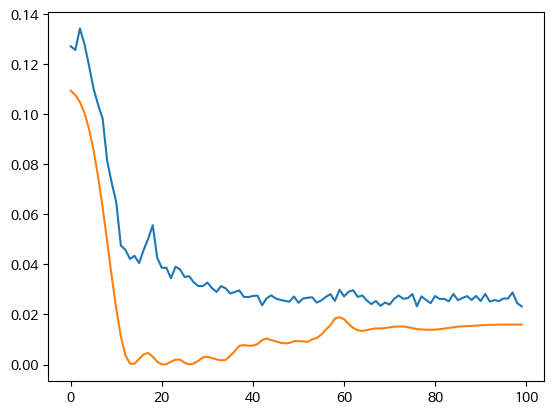

In [110]:
m = NeuralProphet(

growth='off', # 추세 유형 설정(linear, discontinuous, off 중 선택 가능)

yearly_seasonality=False, #년간 계절성 설정

weekly_seasonality=False, #주간 계절성 설정

daily_seasonality=False, #일간 계절성 설정

batch_size=16,#배치 사이즈 설정

epochs=100,#학습 횟수 설정 4

learning_rate=0.1, # 학습률 설정

#n_lags= 1, #이미 lag 데이터를 생성하였으므로 옵션 설정X
    
)

#독립 변인(변수) 추가 및 정규화
m = m.add_lagged_regressor(names=['l'], normalize="minmax") 

#예측 연월 기준으로 예측 연월 이전 data를 train, test 데이터로 분할
data = df1[df1['ds']<ref_month]
data
train, test = m.split_df(data, freq='M', valid_p = 0.10)

#학습 수행
metrics = m.fit(train, freq='M', validation_df=test, progress='plot')


In [111]:
metrics.tail(3)

MAE_val  RMSE_val  Loss_val  RegLoss_val  epoch   MAE  RMSE  Loss  RegLoss
97    3,305     3,305         0            0     97 4,330 4,953     0        0
98    3,305     3,305         0            0     98 3,941 4,651     0        0
99    3,305     3,305         0            0     99 3,767 4,367     0        0

MAE = (Train의 MAE) \
MAE_val = (Test의 MAE) 

In [112]:
px.line(metrics, y=['MAE', 'MAE_val'], width=800, height=400)

FigureWidgetResampler({
    'data': [{'hovertemplate': 'variable=MAE<br>index=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'MAE',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': 'MAE',
              'orientation': 'v',
              'showlegend': True,
              'type': 'scatter',
              'uid': '597d683f-69b3-4f76-a3dc-a6a9f3b51e9b',
              'x': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
                          18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
                          36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
                          54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
                          72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
                          90, 9

Predicting: 2it [00:00, ?it/s]

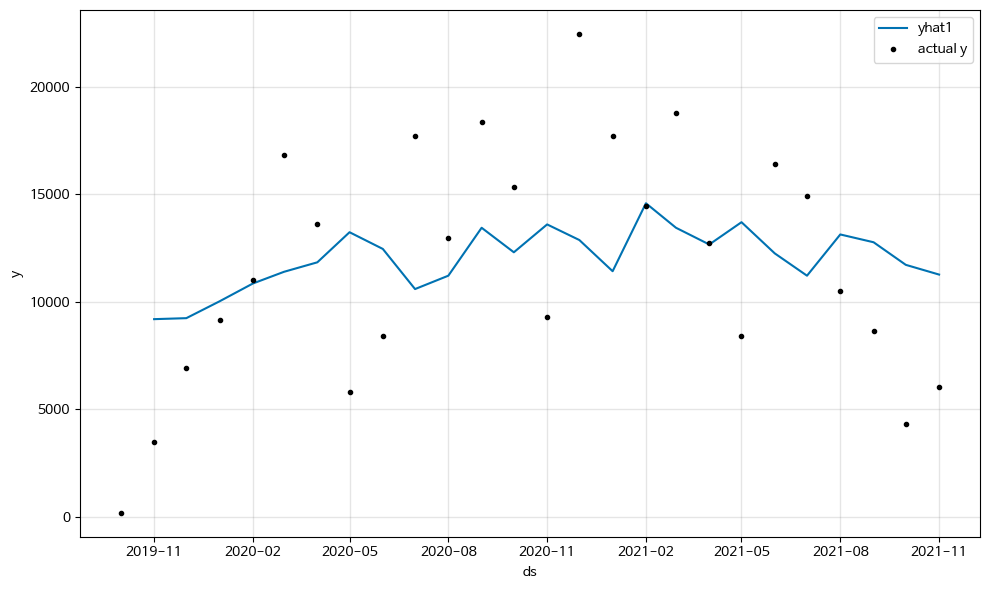

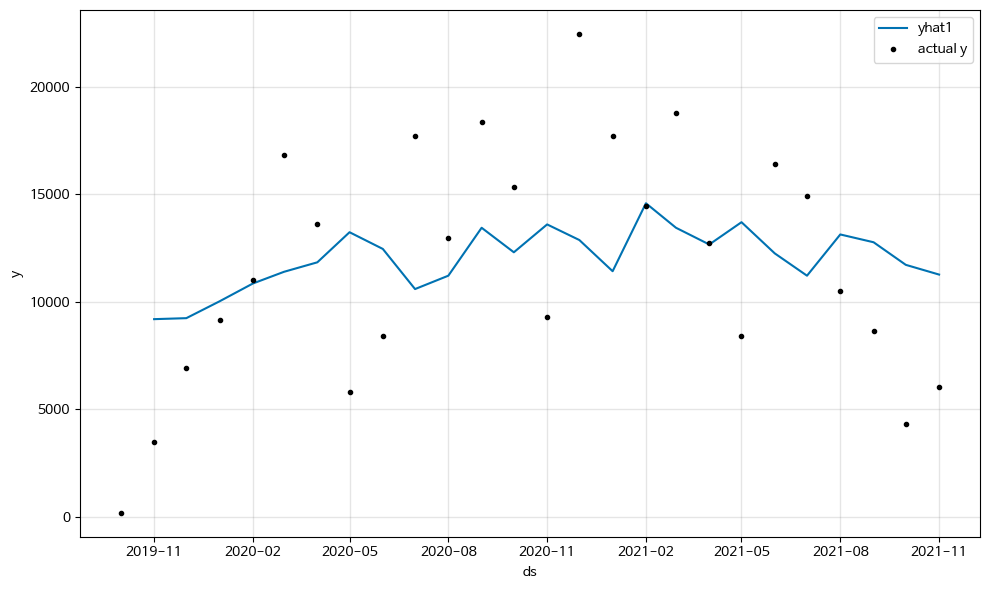

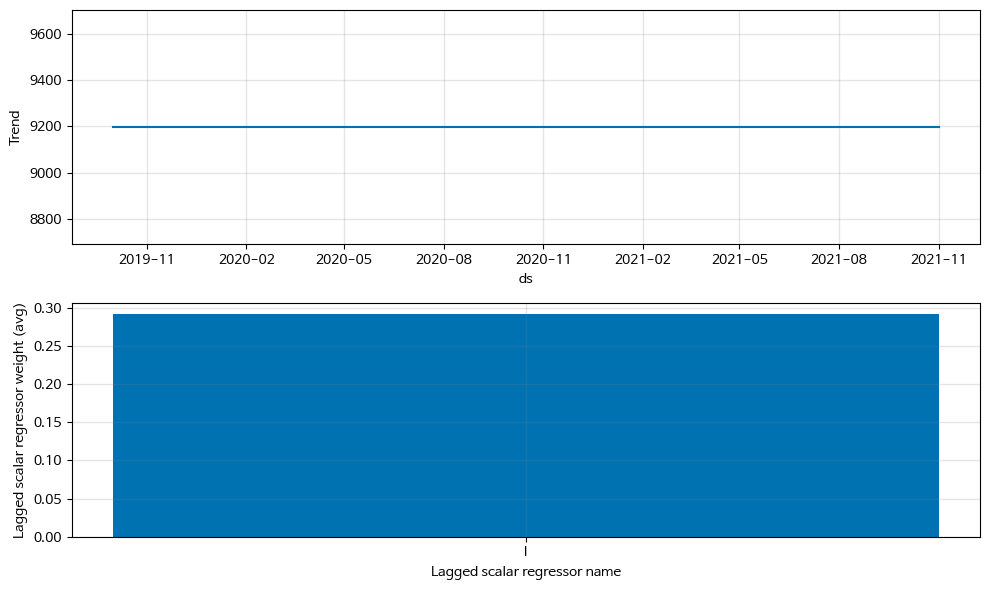

In [113]:
#학습 데이터셋 예측 결과 시각화
train_pred = m.predict(train)
#fig = m.plot(train_pred)
fig1 = m.plot(train_pred[-30*24*6:])
fig2 = m.plot(train_pred[-7*24*6:])
#comp = m.plot_components(train_pred)
param = m.plot_parameters()

Predicting: 2it [00:00, ?it/s]

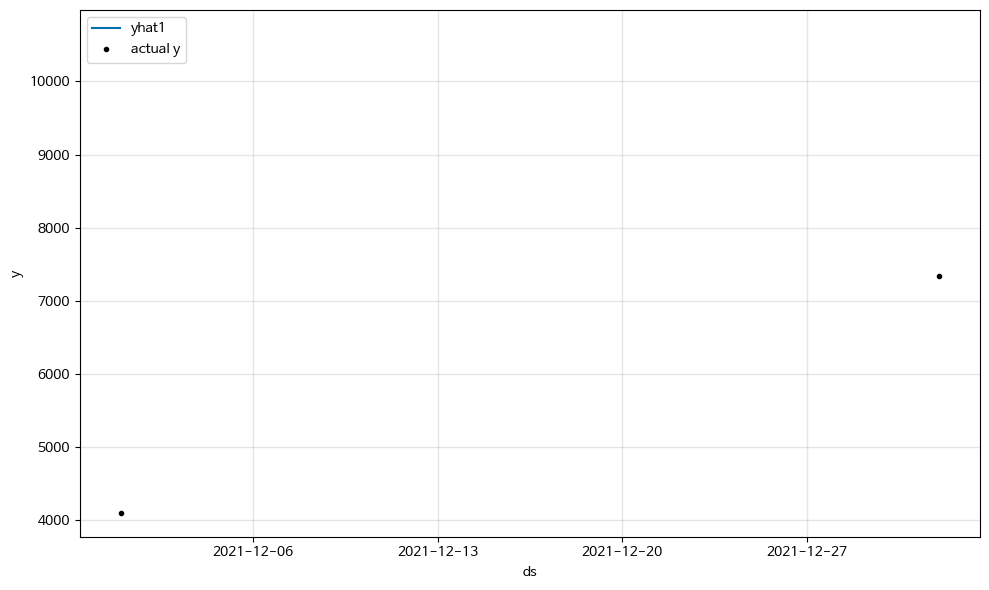

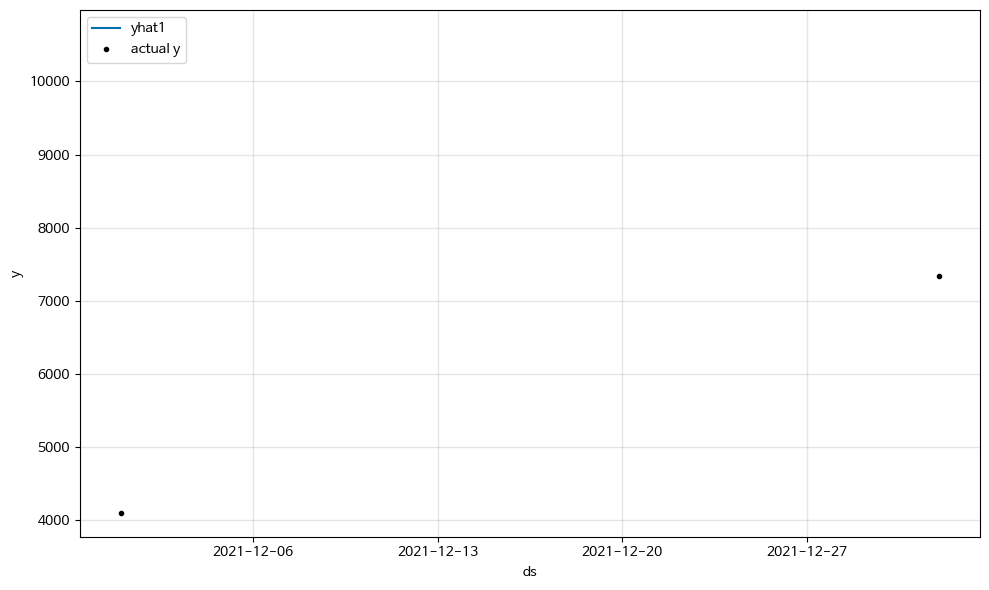

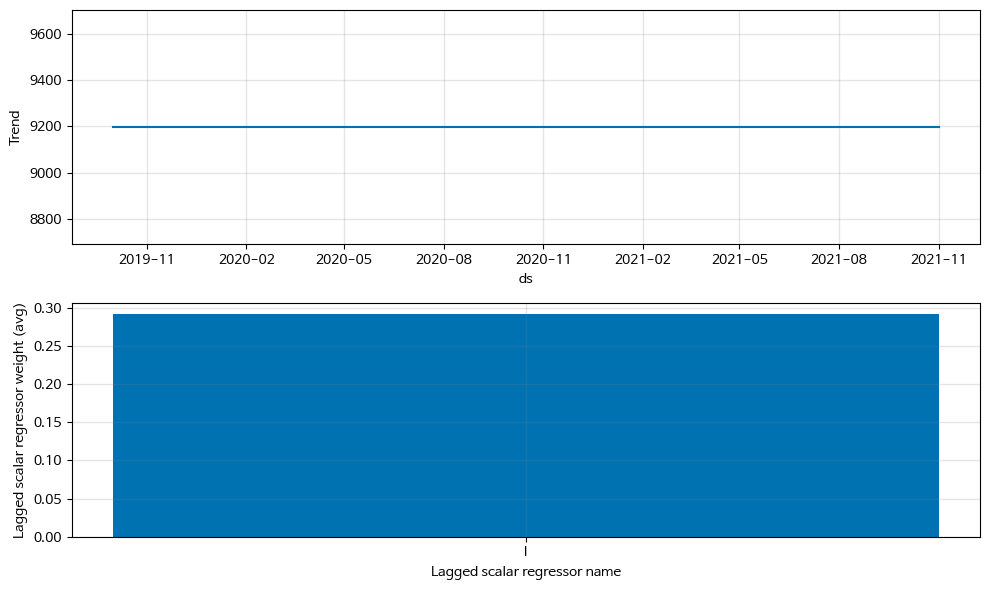

In [114]:
#테스트 데이터셋 예측 결과 시각화
test_pred = m.predict(test)
#fig = m.plot(test_pred)
fig1 = m.plot(test_pred[-14*24*6:])
fig2 = m.plot(test_pred[-7*24*6:])
#comp = m.plot_components(test_pred)
param = m.plot_parameters()

- ARX model \
model에 대해 AR과정 그리고 X독립변수들에 대해서도 변수를 추가 활용하여 시계열 모델을 구축한 뒤, \
이전 시간 단계의 데이터들을 모델이 학습하여 다음 시간 단계들에 대한 예측을 위해 사용해볼 것이다.


모델 설계에서는 MAE를 최대한 낮출 수 있도록 파라미터를 조정하였으며, ARX모델 설계를 위해

주간, 일간,년 간 계절성에 대한 설정을 배제하였습니다. 또한 추세유형은 off로 설정하였으며,

위의 데이터 전처리에서 수행한 lag를 2만큼 사용하였으므로 n_lags를 2로 설정하였습니다.

여기서 2-step이 아니라, 다른 인수를 원한다면 데이터 전처리 부분부터 원하는 인수만큼 데이터를 lag 시킨 뒤,

모델 학습이 가능합니다. add_lagged_regressor에서는 lag된 X설명변수, lag된 Y예측변수를 모두 모델의

설명변수로 활용하였습니다.

In [117]:
#최종독립변수 이름 생성
col_lst=data_pret.columns
col_lst=col_lst.drop(['ds','y'])
col_lst=list(col_lst)
col_lst

['PLAN_QTY',
 'hdays',
 'USD',
 'CNY',
 'EUR',
 'MXN',
 'KH_PETROL',
 'K_PETROL',
 'K_DIESEL',
 'PETROL95',
 'PETROL92',
 'DIESEL001',
 'DIESEL05',
 'CPI_ALL',
 'CPI_CAR',
 'CPI_USA',
 'CPI_CHN',
 'CCSI',
 'LCI',
 'CCI',
 'LAGCI',
 'PLAN_QTY_diff',
 'hdays_diff',
 'USD_diff',
 'CNY_diff',
 'EUR_diff',
 'MXN_diff',
 'KH_PETROL_diff',
 'K_PETROL_diff',
 'K_DIESEL_diff',
 'PETROL95_diff',
 'PETROL92_diff',
 'DIESEL001_diff',
 'DIESEL05_diff',
 'CPI_ALL_diff',
 'CPI_CAR_diff',
 'CPI_USA_diff',
 'CPI_CHN_diff',
 'CCSI_diff',
 'LCI_diff',
 'CCI_diff',
 'LAGCI_diff',
 'PLAN_QTY_diff2',
 'hdays_diff2',
 'USD_diff2',
 'CNY_diff2',
 'EUR_diff2',
 'MXN_diff2',
 'KH_PETROL_diff2',
 'K_PETROL_diff2',
 'K_DIESEL_diff2',
 'PETROL95_diff2',
 'PETROL92_diff2',
 'DIESEL001_diff2',
 'DIESEL05_diff2',
 'CPI_ALL_diff2',
 'CPI_CAR_diff2',
 'CPI_USA_diff2',
 'CPI_CHN_diff2',
 'CCSI_diff2',
 'LCI_diff2',
 'CCI_diff2',
 'LAGCI_diff2',
 'y_diff',
 'y_diff2']

> 'ds','y','PLAN_QTY','PLAN_QTY_diff','PLAN_QTY_diff2', 'y_diff','y_diff2' \
[계획 판매량, 공휴일,그 외 변수들] 넣어서 만든 데이터프레임 data_pret


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

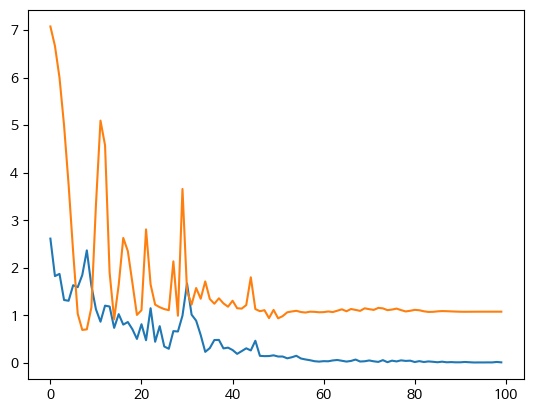

In [118]:
m = NeuralProphet(

growth='off', # 추세 유형 설정(linear, discontinuous, off 중 선택 가능)

yearly_seasonality=False, #년간 계절성 설정

weekly_seasonality=False, #주간 계절성 설정

daily_seasonality=False, #일간 계절성 설정

batch_size=10,#배치 사이즈 설정

epochs=100,#학습 횟수 설정 4

learning_rate=0.1, # 학습률 설정

n_lags= 2, #lag를 2까지 사용하였으므로, lag를 2로 설정

)

#독립 변인(변수) 추가 및 정규화
m = m.add_lagged_regressor(names=col_lst, normalize="minmax") 

#예측 연월 기준으로 예측 연월 이전 data를 train, test 데이터로 분할
data = data_pret[data_pret['ds']<ref_month]
data
train, test = m.split_df(data, freq='M', valid_p = 0.10)

#학습 수행
metrics = m.fit(train, freq='M', validation_df=test, progress='plot')


In [119]:
metrics

MAE_val  RMSE_val  Loss_val  RegLoss_val  epoch    MAE   RMSE  Loss  \
0   109,152   111,656         7            0      0 50,487 64,016     3   
1   103,256   105,816         7            0      1 38,542 49,837     2   
2    93,631    96,302         6            0      2 38,148 50,009     2   
3    79,184    82,083         5            0      3 33,024 41,930     1   
4    61,181    64,535         4            0      4 34,496 44,378     1   
5    40,752    45,112         2            0      5 38,697 41,316     2   
6    18,826    26,128         1            0      6 37,663 41,709     2   
7    17,183    17,219         1            0      7 44,152 49,839     2   
8    17,355    17,355         1            0      8 48,268 56,413     2   
9    21,562    28,772         1            0      9 36,375 42,910     2   
10   55,067    59,162         3            0     10 27,981 34,883     1   
11   80,622    84,075         5            0     11 22,759 28,115     1   
12   73,135    76,931         5            0     12 27,629 33,042     1   
13   34,525    40,838         2            0     13 28,307 37,373     1   
14   20,364    21,648         1            0     14 19,673 24,295     1   
15   30,237    37,312         2            0     15 26,703 32,611     1   
16   45,069    50,586         3            0     16 22,388 27,803     1   
17   41,084    47,089         2            0     17 21,727 26,150     1   
18   30,766    38,291         2            0     18 19,180 23,090     1   
19   21,731    21,752         1            0     19 15,283 18,827     1   
20   23,154    23,673         1            0     20 21,556 24,110     1   
21   47,651    54,532         3            0     21 13,260 17,906     0   
22   28,978    38,426         2            0     22 29,483 31,930     1   
23   22,080    29,995         1            0     23 14,096 16,326     0   
24   24,069    25,138         1            0     24 19,421 22,702     1   
25   23,502    23,516         1            0     25 11,663 14,540     0   
26   23,167    24,286         1            0     26 11,640 13,371     0   
27   37,945    45,203         2            0     27 18,168 19,675     1   
28   21,144    23,911         1            0     28 18,471 19,804     1   
29   59,906    65,422         4            0     29 24,316 26,072     1   
30   26,146    35,824         2            0     30 37,681 39,080     2   
31   24,083    29,108         1            0     31 24,586 26,140     1   
32   26,885    37,141         2            0     32 21,917 23,455     1   
33   25,931    31,513         1            0     33 15,856 18,133     1   
34   29,018    39,952         2            0     34  9,123 11,615     0   
35   26,529    29,637         1            0     35 10,914 12,859     0   
36   25,127    27,460         1            0     36 13,164 15,804     0   
37   26,696    30,287         1            0     37 15,019 16,213     0   
38   25,227    25,909         1            0     38  9,872 12,011     0   
39   24,213    26,044         1            0     39 12,209 13,269     0   
40   25,065    30,929         1            0     40 10,592 11,774     0   
41   23,764    23,784         1            0     41  9,384 10,421     0   
42   22,860    27,433         1            0     42  9,009 10,396     0   
43   24,714    26,502         1            0     43 11,291 12,365     0   
44   32,946    39,529         2            0     44 10,738 12,142     0   
45   23,506    23,622         1            0     45 14,101 16,046     0   
46   21,594    26,717         1            0     46  8,114  8,938     0   
47   22,613    26,526         1            0     47  7,161  8,488     0   
48   20,379    23,013         1            0     48  7,066  8,153     0   
49   21,720    27,403         1            0     49  7,951  8,749     0   
50   20,701    20,707         1            0     50  7,349  8,227     0   
51   21,369    21,403         1            0     51  7,298  8,232     0   
52   22,521    23,478        

In [120]:
metrics.tail(3)


MAE_val  RMSE_val  Loss_val  RegLoss_val  epoch   MAE  RMSE  Loss  RegLoss
97   22,714    22,997         1            0     97 1,835 2,130     0        0
98   22,714    22,997         1            0     98 2,589 2,853     0        0
99   22,714    22,997         1            0     99 1,978 2,293     0        0

In [121]:
#metric 확인
print("Loss: ", metrics.Loss.tail(1).item())
print("MAE(Train): ", metrics.MAE.tail(1).item())
print("MAE(Test): ", metrics.MAE_val.tail(1).item())

Loss:  0.010519939474761486
MAE(Train):  1977.889404296875
MAE(Test):  22714.1796875


In [122]:
#학습 선 그래프 생성
loss= px.line(metrics, y=['MAE', 'MAE_val'], width=800, height=400)
loss.show()

Predicting: 3it [00:00, ?it/s]

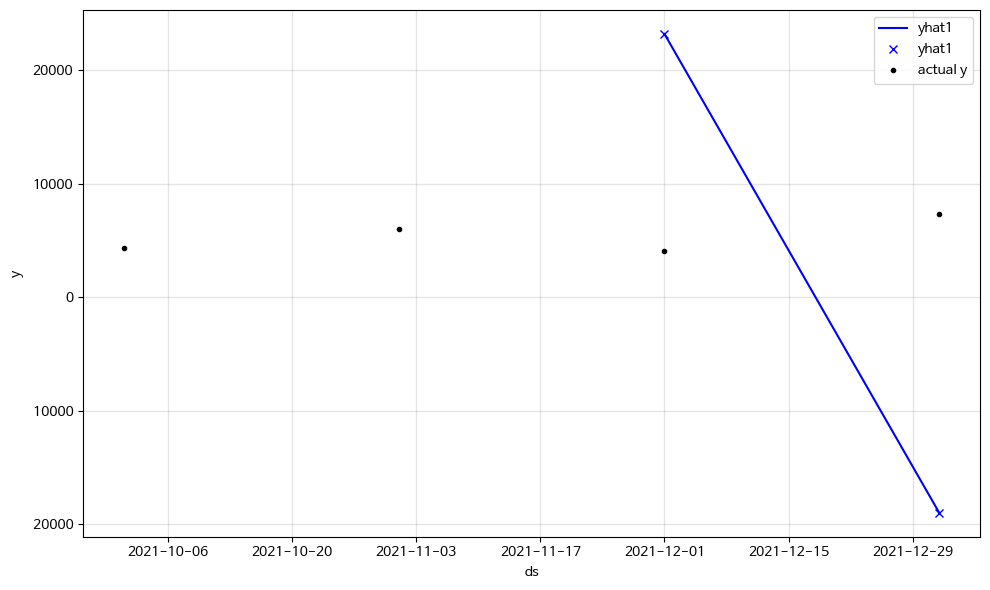

In [123]:
#yhat1과 실제값 시각화(lag 데이터 포함O)
forecast = m.predict(test)
m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig = m.plot(forecast)
fig.show()


Predicting: 3it [00:00, ?it/s]

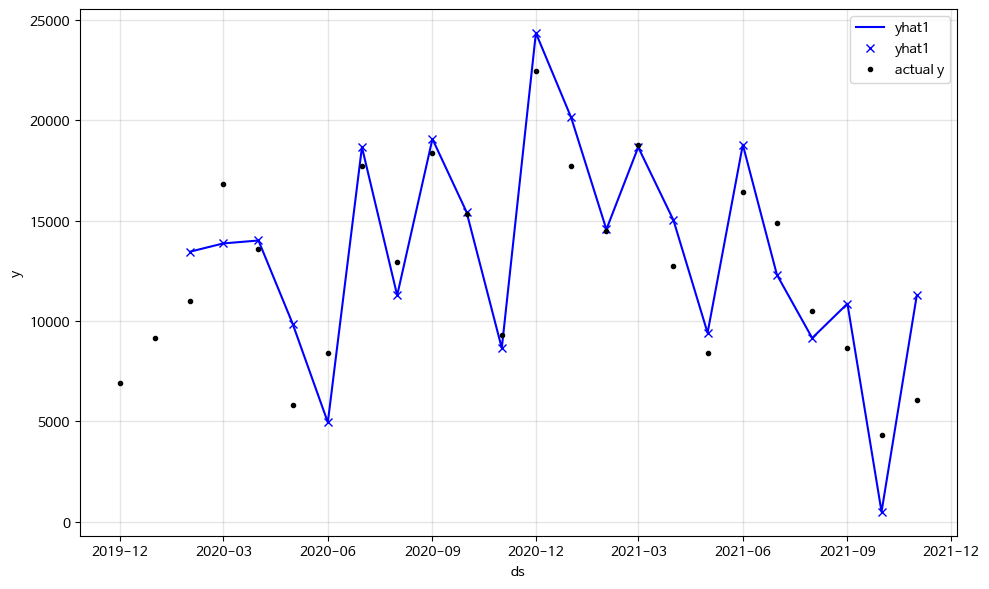

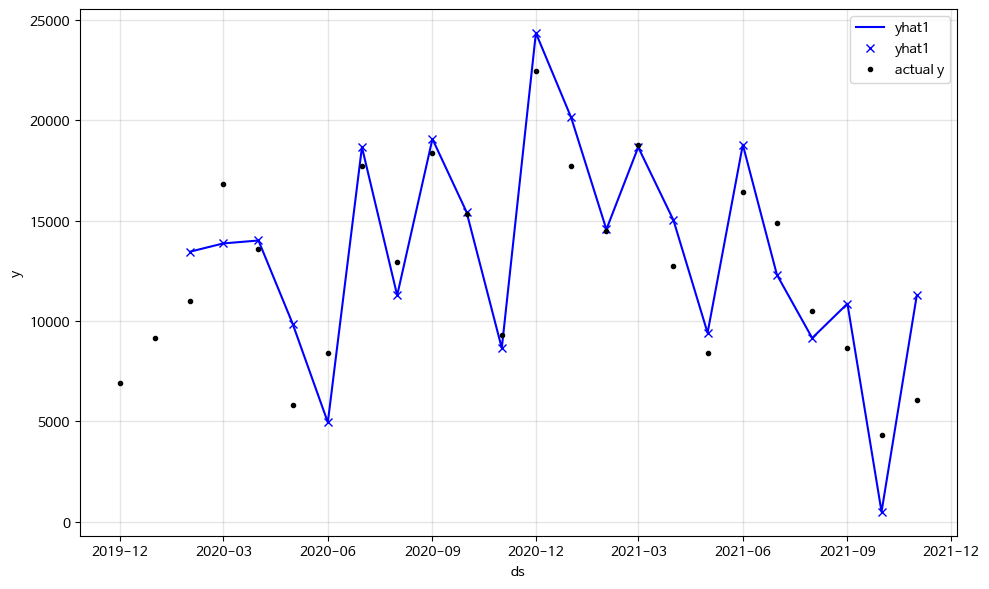

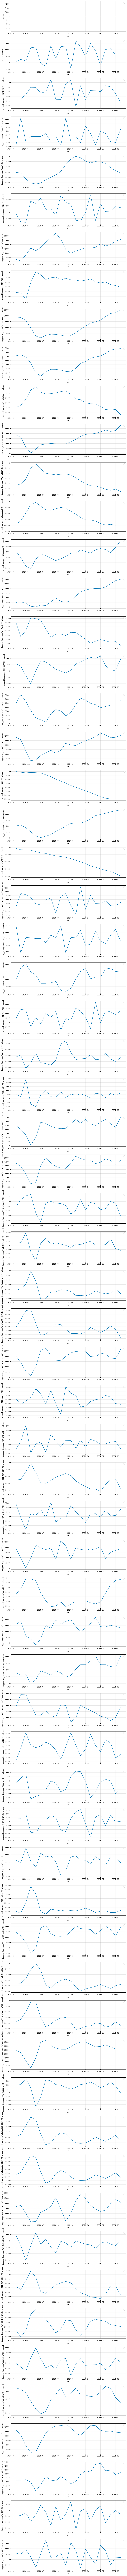

In [124]:
#학습 데이터셋 예측 결과 시각화
train_pred = m.predict(train)
#fig = m.plot(train_pred)
fig1 = m.plot(train_pred[-30*24*6:])
fig2 = m.plot(train_pred[-7*24*6:])
comp = m.plot_components(train_pred)
#param = m.plot_parameters()

In [127]:
forecast = m.predict(test)
forecast

Predicting: 3it [00:00, ?it/s]

ds     y   yhat1    ar1  lagged_regressor_PLAN_QTY1  \
0 2021-10-01 4,320     NaN    NaN                         NaN   
1 2021-11-01 6,048     NaN    NaN                         NaN   
2 2021-12-01 4,104  23,220 -1,099                        -558   
3 2022-01-01 7,344 -18,968  2,540                         468   

   lagged_regressor_hdays1  lagged_regressor_USD1  lagged_regressor_CNY1  \
0                      NaN                    NaN                    NaN   
1                      NaN                    NaN                    NaN   
2                    5,362                 -7,019                  2,479   
3                   -1,543                 -7,046                  2,963   

   lagged_regressor_EUR1  lagged_regressor_MXN1  ...  \
0                    NaN                    NaN  ...   
1                    NaN                    NaN  ...   
2                 22,265                 -5,791  ...   
3                 16,452                 -4,839  ...   

   lagged_regressor_CPI_CAR_diff21  lagged_regressor_CPI_USA_diff21  \
0                              NaN                              NaN   
1                              NaN                              NaN   
2                             -507                           -9,633   
3                             -890                           -6,091   

   lagged_regressor_CPI_CHN_diff21  lagged_regressor_CCSI_diff21  \
0                              NaN                           NaN   
1                              NaN                           NaN   
2                          -23,496                        -2,709   
3                          -21,261                        -3,646   

   lagged_regressor_LCI_diff21  lagged_regressor_CCI_diff21  \
0                          NaN                          NaN   
1                          NaN                          NaN   
2                          658                        9,849   
3                       -1,358                       11,670   

   lagged_regressor_LAGCI_diff21  lagged_regressor_y_diff1  \
0                            NaN                       NaN   
1                            NaN                       NaN   
2                         13,990                       953   
3                         15,881                    -5,561   

   lagged_regressor_y_diff21  trend  
0                        NaN    NaN  
1                        NaN    NaN  
2                      5,103  6,889  
3                      5,333  6,889  

[4 rows x 70 columns]

최적화 model : Using a Neural Network

1. 은닉층 사용
2. 이전 시간 단계의 데이터를 모델이 학습하여 다음 시간 단계에 대한 예측 후 검증 데이터와 비교

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

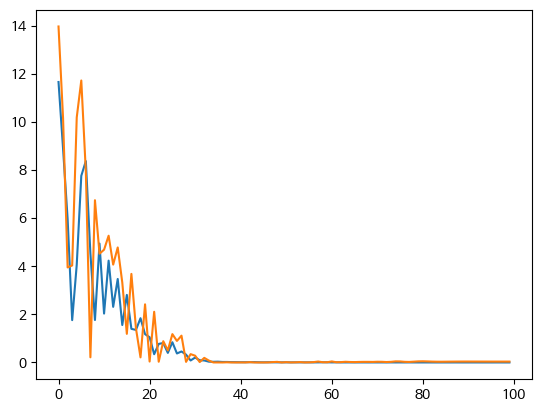

In [128]:
m = NeuralProphet(

growth='off', # 추세 유형 설정(linear, discontinuous, off 중 선택 가능)

yearly_seasonality=False, #년간 계절성 설정

weekly_seasonality=False, #주간 계절성 설정

daily_seasonality=False, #일간 계절성 설정

batch_size=16,#배치 사이즈 설정

epochs=100,#학습 횟수 설정

learning_rate=0.1, # 학습률 설정

n_lags= 2, #lag를 2까지 사용하였으므로, lag를 2로 설정

num_hidden_layers=4, #히든 레이어 수 설정

d_hidden=8,#은닉층에 대한 차원 수 설정


)

#독립 변인(변수) 추가 및 정규화
m = m.add_lagged_regressor(names=col_lst, normalize="minmax") 

#예측 연월 기준으로 예측 연월 이전 data를 train, test 데이터로 분할
ref_month = '2022-02'
data = data_pret[data_pret['ds']<ref_month]
train, test = m.split_df(data, freq='M', valid_p = 0.10)

#학습 수행
metrics = m.fit(train, freq='M', validation_df=test, progress='plot')

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

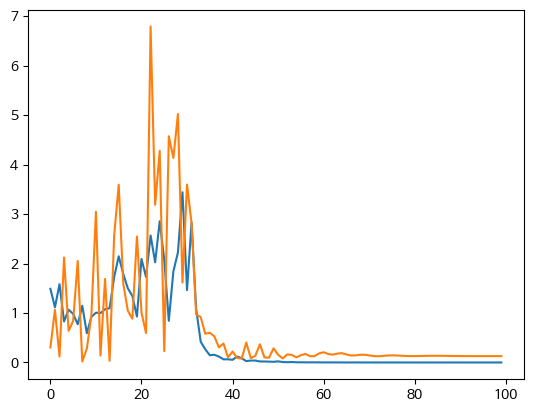

In [129]:
m = NeuralProphet(

growth='off', # 추세 유형 설정(linear, discontinuous, off 중 선택 가능)

yearly_seasonality=10, #년간 계절성 설정

weekly_seasonality=10, #주간 계절성 설정

daily_seasonality=False, #일간 계절성 설정

batch_size=16,#배치 사이즈 설정

epochs=100,#학습 횟수 설정

learning_rate=0.1, # 학습률 설정

n_lags= 2, #lag를 2까지 사용하였으므로, lag를 2로 설정

num_hidden_layers=4, #히든 레이어 수 설정

d_hidden=8,#은닉층에 대한 차원 수 설정


)

#독립 변인(변수) 추가 및 정규화
m = m.add_lagged_regressor(names=col_lst, normalize="minmax") 

#예측 연월 기준으로 예측 연월 이전 data를 train, test 데이터로 분할
ref_month = '2022-02'
data = data_pret[data_pret['ds']<ref_month]
train, test = m.split_df(data, freq='M', valid_p = 0.10)

#학습 수행
metrics = m.fit(train, freq='M', validation_df=test, progress='plot')

In [130]:
#metric 확인
print("SmoothL1Loss: ", metrics.Loss.tail(1).item())
print("MAE(Train): ", metrics.MAE.tail(1).item())
print("MAE(Test): ", metrics.MAE_val.tail(1).item())

SmoothL1Loss:  4.7270088543882594e-05
MAE(Train):  118.19039916992188
MAE(Test):  7267.68310546875


In [131]:
#학습 선 그래프 생성
loss= px.line(metrics, y=['MAE', 'MAE_val'], width=800, height=400)
loss.show()

Predicting: 2it [00:00, ?it/s]

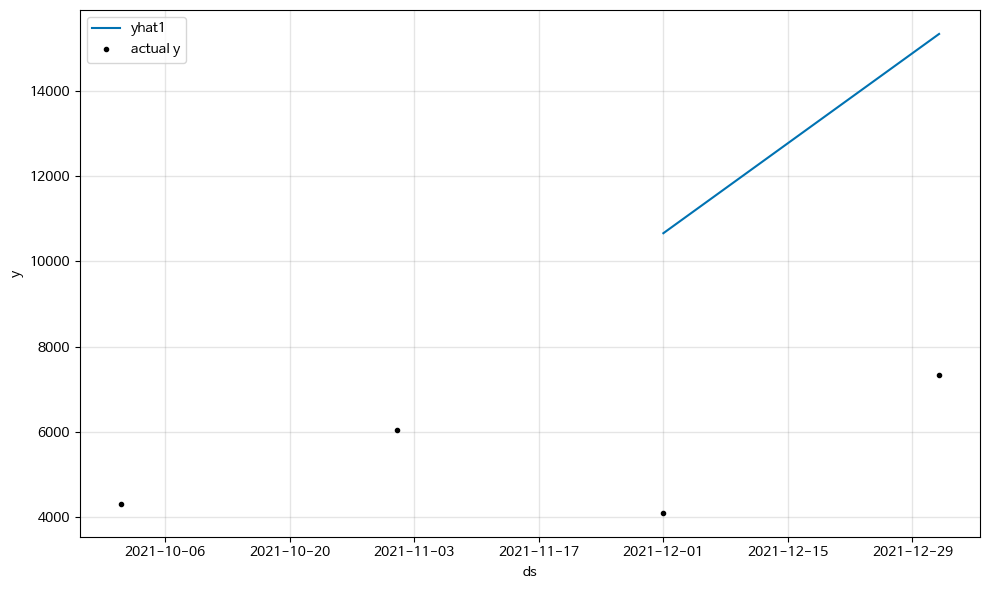

In [132]:
#yhat1과 실제값 시각화(lag 데이터 포함x)
forecast = m.predict(test)
fig = m.plot(forecast[['ds', 'y', 'yhat1']])
fig.show()

Predicting: 2it [00:00, ?it/s]

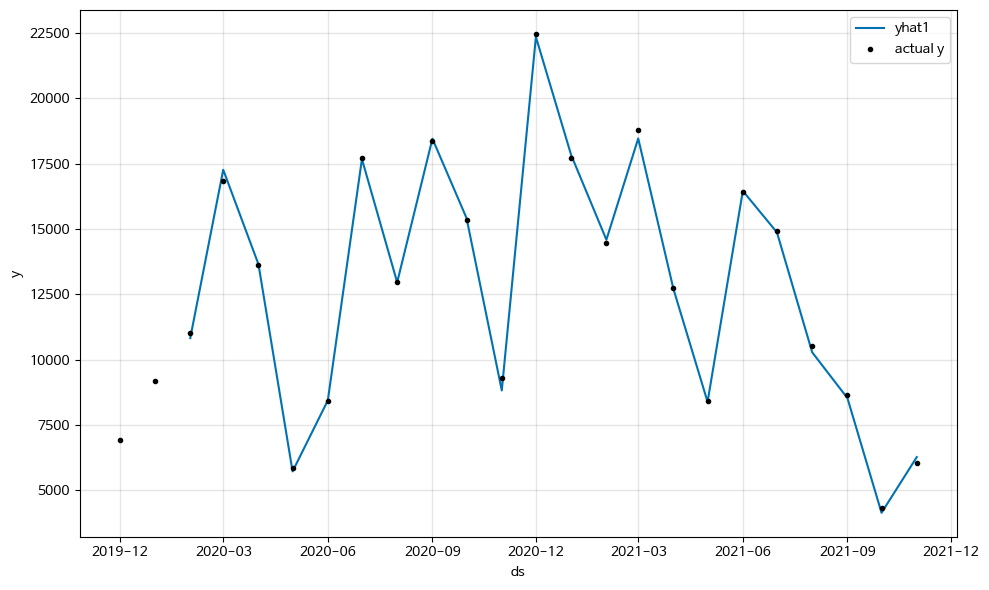

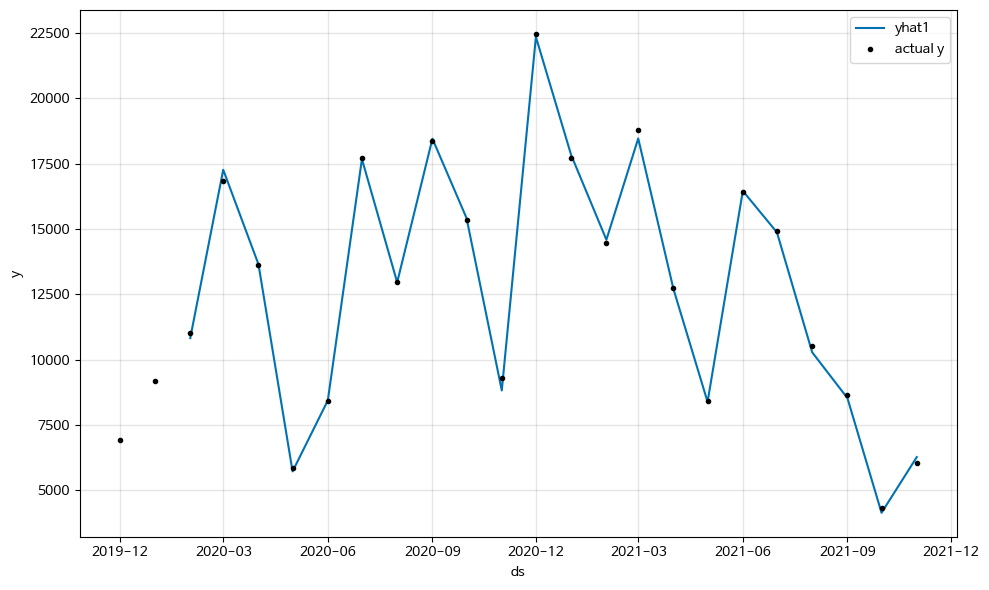

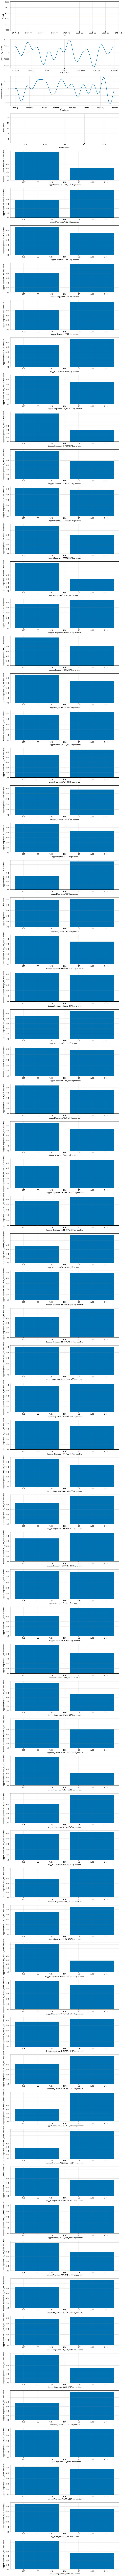

In [133]:
#학습 데이터셋 예측 결과 시각화
train_pred = m.predict(train)
#fig = m.plot(train_pred)
fig1 = m.plot(train_pred[-30*24*6:])
fig2 = m.plot(train_pred[-7*24*6:])
#comp = m.plot_components(train_pred)
param = m.plot_parameters()

> 'ds','y','PLAN_QTY','PLAN_QTY_diff','PLAN_QTY_diff2', 'y_diff','y_diff2' \
[계획 판매량, 공휴일]만 넣어서 만든 데이터프레임 data_pret2


In [136]:
data_pret2 = data_pret[['ds','y','PLAN_QTY','hdays','PLAN_QTY_diff','hdays_diff', 'y_diff', 'PLAN_QTY_diff2', 'hdays_diff2' ,'y_diff2']]
data_pret2

ds      y  PLAN_QTY  hdays  PLAN_QTY_diff  hdays_diff  y_diff  \
0   2019-12  6,912         0      1              0           1   3,450   
1   2020-01  9,180    16,644      4         16,644           3   2,268   
2   2020-02 11,016    28,988      0         12,344          -4   1,836   
3   2020-03 16,848    34,308      1          5,320           1   5,832   
4   2020-04 13,608    31,176      1         -3,132           0  -3,240   
5   2020-05  5,832    28,836      1         -2,340           0  -7,776   
6   2020-06  8,424    32,666      1          3,830           0   2,592   
7   2020-07 17,712    34,308      0          1,642          -1   9,288   
8   2020-08 12,960    23,332      1        -10,976           1  -4,752   
9   2020-09 18,360    34,652      1         11,320           0   5,400   
10  2020-10 15,336    43,428      4          8,776           3  -3,024   
11  2020-11  9,288    34,652      0         -8,776          -4  -6,048   
12  2020-12 22,464    24,504      1        -10,148           1  13,176   
13  2021-01 17,712    43,180      1         18,676           0  -4,752   
14  2021-02 14,472    36,346      3         -6,834           2  -3,240   
15  2021-03 18,792    44,774      1          8,428          -2   4,320   
16  2021-04 12,744    42,374      0         -2,400          -1  -6,048   
17  2021-05  8,424    40,724      2         -1,650           2  -4,320   
18  2021-06 16,416    40,320      1           -404          -1   7,992   
19  2021-07 14,904    34,144      0         -6,176          -1  -1,512   
20  2021-08 10,526    30,520      1         -3,624           1  -4,378   
21  2021-09  8,640    34,514      3          3,994           2  -1,886   
22  2021-10  4,320    46,104      2         11,590          -1  -4,320   
23  2021-11  6,048    48,178      0          2,074          -2   1,728   
24  2021-12  4,104    26,248      1        -21,930           1  -1,944   
25  2022-01  7,344    26,056      2           -192           1   3,240   
26  2022-02 11,016    28,678      2          2,622           0   3,672   

    PLAN_QTY_diff2  hdays_diff2  y_diff2  
0                0           -1    6,720  
1           16,644            4    5,718  
2           28,988           -1    4,104  
3           17,664           -3    7,668  
4            2,188            1    2,592  
5           -5,472            0  -11,016  
6            1,490            0   -5,184  
7            5,472           -1   11,880  
8           -9,334            0    4,536  
9              344            1      648  
10          20,096            3    2,376  
11               0           -1   -9,072  
12         -18,924           -3    7,128  
13           8,528            1    8,424  
14          11,842            2   -7,992  
15           1,594            0    1,080  
16           6,028           -3   -1,728  
17          -4,050            1  -10,368  
18          -2,054            1    3,672  
19          -6,580           -2    6,480  
20          -9,800            0   -5,890  
21             370            3   -6,264  
22          15,584            1   -6,206  
23          13,664           -3   -2,592  
24         -19,856           -1     -216  
25         -22,122            2    1,296  
26           2,430            1    6,912

In [137]:
#최종독립변수 이름 생성 ds, y를 제외한 변수들
col_lst2 = data_pret2.columns
col_lst2 = col_lst2.drop(['ds','y'])
col_lst2 = list(col_lst2)
col_lst2

['PLAN_QTY',
 'hdays',
 'PLAN_QTY_diff',
 'hdays_diff',
 'y_diff',
 'PLAN_QTY_diff2',
 'hdays_diff2',
 'y_diff2']

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

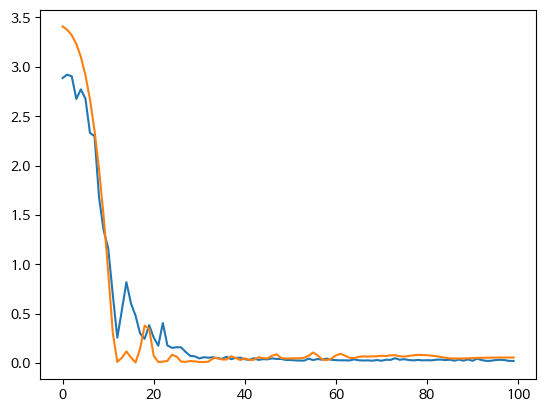

In [138]:
m = NeuralProphet(

growth='off', # 추세 유형 설정(linear, discontinuous, off 중 선택 가능)

yearly_seasonality=False, #년간 계절성 설정

weekly_seasonality=False, #주간 계절성 설정

daily_seasonality=False, #일간 계절성 설정

batch_size=10,#배치 사이즈 설정

epochs=100,#학습 횟수 설정 4

learning_rate=0.1, # 학습률 설정

n_lags= 2, #lag를 2까지 사용하였으므로, lag를 2로 설정

)

#독립 변인(변수) 없이 정규화
m = m.add_lagged_regressor(names = col_lst2, normalize = "minmax")

#예측 연월 기준으로 예측 연월 이전 data를 train, test 데이터로 분할
ref_month = '2022-02'
data2 = data_pret2[data_pret2['ds']<ref_month]
train2, test2 = m.split_df(data2, freq='M', valid_p = 0.10)

#학습 수행
metrics = m.fit(train2, freq='M', validation_df=test2, progress='plot')


In [139]:
metrics

MAE_val  RMSE_val  Loss_val  RegLoss_val  epoch    MAE   RMSE  Loss  \
0    56,316    56,830         3            0      0 62,391 63,723     3   
1    55,832    56,340         3            0      1 68,291 71,224     3   
2    55,036    55,536         3            0      2 62,971 65,025     3   
3    53,765    54,252         3            0      3 58,196 60,549     3   
4    51,873    52,340         3            0      4 58,070 61,140     3   
5    49,214    49,654         3            0      5 62,130 64,165     3   
6    45,672    46,076         3            0      6 51,659 53,658     2   
7    41,119    41,477         2            0      7 52,066 54,253     2   
8    35,434    35,735         2            0      8 42,263 46,708     2   
9    28,604    28,834         1            0      9 31,963 36,563     1   
10   20,538    20,684         1            0     10 31,110 34,524     1   
11   11,282    11,334         0            0     11 21,699 25,192     1   
12    2,154     2,176         0            0     12  9,775 12,681     0   
13    4,450     4,652         0            0     13 15,665 18,662     1   
14    6,717     6,969         0            0     14 20,901 22,830     1   
15    4,514     4,850         0            0     15 16,903 19,032     1   
16    1,190     1,481         0            0     16 14,987 16,752     0   
17    7,732     7,741         0            0     17 10,919 12,874     0   
18   12,544    12,545         0            0     18 10,395 12,779     0   
19   11,979    11,979         0            0     19 13,772 16,162     0   
20    5,345     5,457         0            0     20 11,137 13,294     0   
21    1,990     2,022         0            0     21  8,012 10,270     0   
22    2,220     2,320         0            0     22 12,923 14,018     0   
23    2,276     3,012         0            0     23  8,186 10,100     0   
24    5,658     5,887         0            0     24  7,018  9,171     0   
25    4,919     5,227         0            0     25  8,274  9,990     0   
26    2,262     2,429         0            0     26  7,977  9,012     0   
27    2,168     2,201         0            0     27  6,382  7,695     0   
28    2,140     2,906         0            0     28  6,020  6,584     0   
29    2,043     2,635         0            0     29  5,516  5,904     0   
30    1,798     2,092         0            0     30  4,031  4,376     0   
31    1,724     1,988         0            0     31  4,985  5,712     0   
32    1,761     2,368         0            0     32  4,904  5,663     0   
33    3,865     4,369         0            0     33  5,183  5,825     0   
34    4,147     4,691         0            0     34  4,434  4,872     0   
35    3,152     3,818         0            0     35  4,016  4,551     0   
36    3,141     3,850         0            0     36  5,547  6,151     0   
37    4,747     5,326         0            0     37  3,912  4,430     0   
38    3,910     4,587         0            0     38  4,702  5,128     0   
39    2,651     3,547         0            0     39  5,378  5,713     0   
40    3,591     4,401         0            0     40  4,055  4,493     0   
41    2,720     3,637         0            0     41  3,654  3,928     0   
42    2,789     3,667         0            0     42  4,358  4,937     0   
43    4,284     4,929         0            0     43  3,701  4,089     0   
44    3,902     4,533         0            0     44  4,014  4,393     0   
45    3,796     4,382         0            0     45  4,008  4,461     0   
46    5,008     5,539         0            0     46  4,237  4,893     0   
47    5,469     6,037         0            0     47  4,131  4,606     0   
48    3,858     4,530         0            0     48  3,931  4,599     0   
49    3,603     4,309         0            0     49  3,369  3,941     0   
50    3,601     4,392         0            0     50  3,235  3,920     0   
51    3,572     4,463         0            0     51  3,367  3,855     0   
52    3,498     4,472        

In [140]:
metrics.tail(3)

MAE_val  RMSE_val  Loss_val  RegLoss_val  epoch   MAE  RMSE  Loss  RegLoss
97    4,001     4,795         0            0     97 3,129 3,951     0        0
98    4,003     4,797         0            0     98 2,552 3,072     0        0
99    4,003     4,797         0            0     99 2,389 2,819     0        0

In [141]:
#metric 확인
print("Loss: ", metrics.Loss.tail(1).item())
print("MAE(Train): ", metrics.MAE.tail(1).item())
print("MAE(Test): ", metrics.MAE_val.tail(1).item())

Loss:  0.020814746618270874
MAE(Train):  2389.424560546875
MAE(Test):  4003.44140625


In [142]:
forecast = m.predict(test2)
forecast

Predicting: 3it [00:00, ?it/s]

ds     y  yhat1  ar1  lagged_regressor_PLAN_QTY1  \
0 2021-10-01 4,320    NaN  NaN                         NaN   
1 2021-11-01 6,048    NaN  NaN                         NaN   
2 2021-12-01 4,104 10,750  125                      -2,299   
3 2022-01-01 7,344  8,705  682                      -1,784   

   lagged_regressor_hdays1  lagged_regressor_PLAN_QTY_diff1  \
0                      NaN                              NaN   
1                      NaN                              NaN   
2                    1,402                            9,580   
3                   -4,157                            3,918   

   lagged_regressor_hdays_diff1  lagged_regressor_y_diff1  \
0                           NaN                       NaN   
1                           NaN                       NaN   
2                        -5,998                    -5,306   
3                        -5,802                   -10,768   

   lagged_regressor_PLAN_QTY_diff21  lagged_regressor_hdays_diff21  \
0                               NaN                            NaN   
1                               NaN                            NaN   
2                            -5,471                            426   
3                                84                          6,254   

   lagged_regressor_y_diff21  trend  
0                        NaN    NaN  
1                        NaN    NaN  
2                      5,940 12,352  
3                      7,927 12,352

In [143]:
#학습 선 그래프 생성
loss= px.line(metrics, y=['MAE', 'MAE_val'], width=800, height=400)
loss.show()

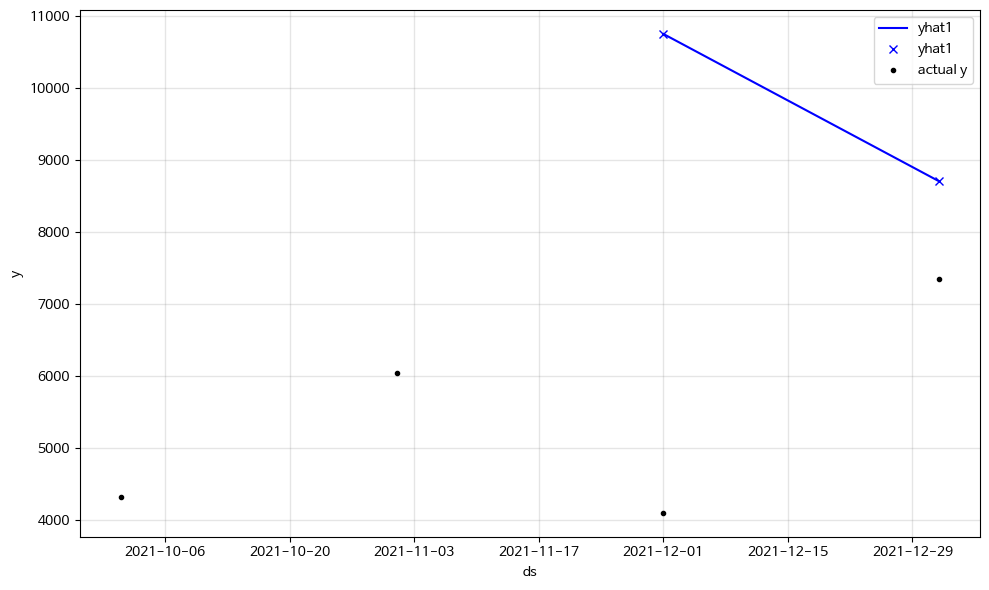

In [144]:
m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig = m.plot(forecast)
fig.show()

Predicting: 3it [00:00, ?it/s]

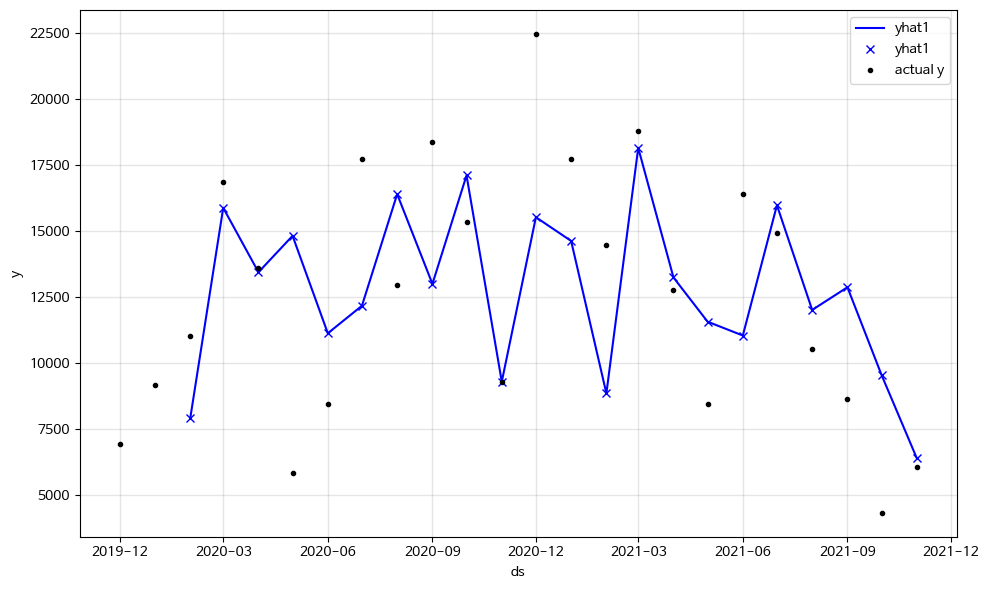

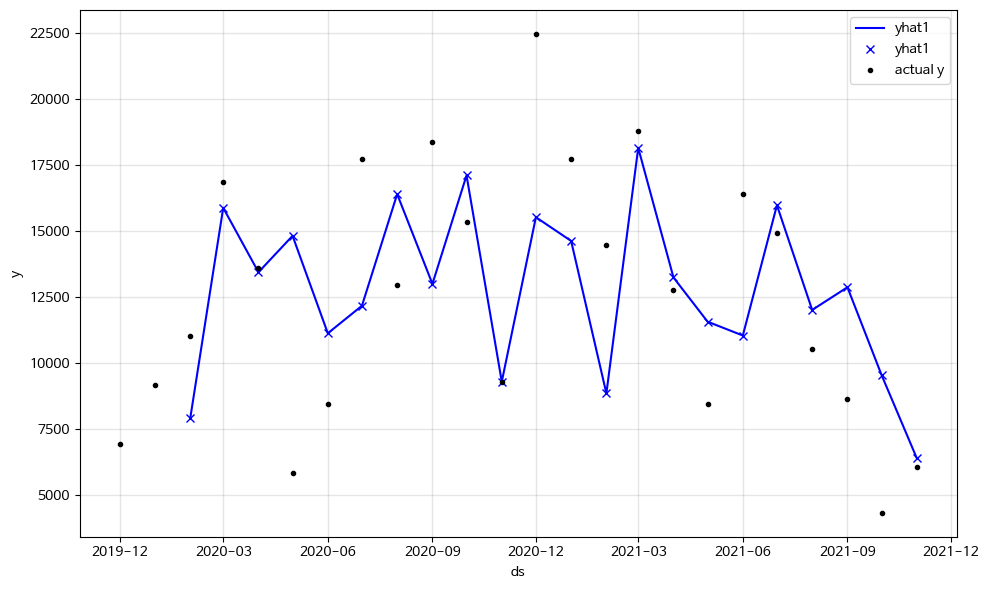

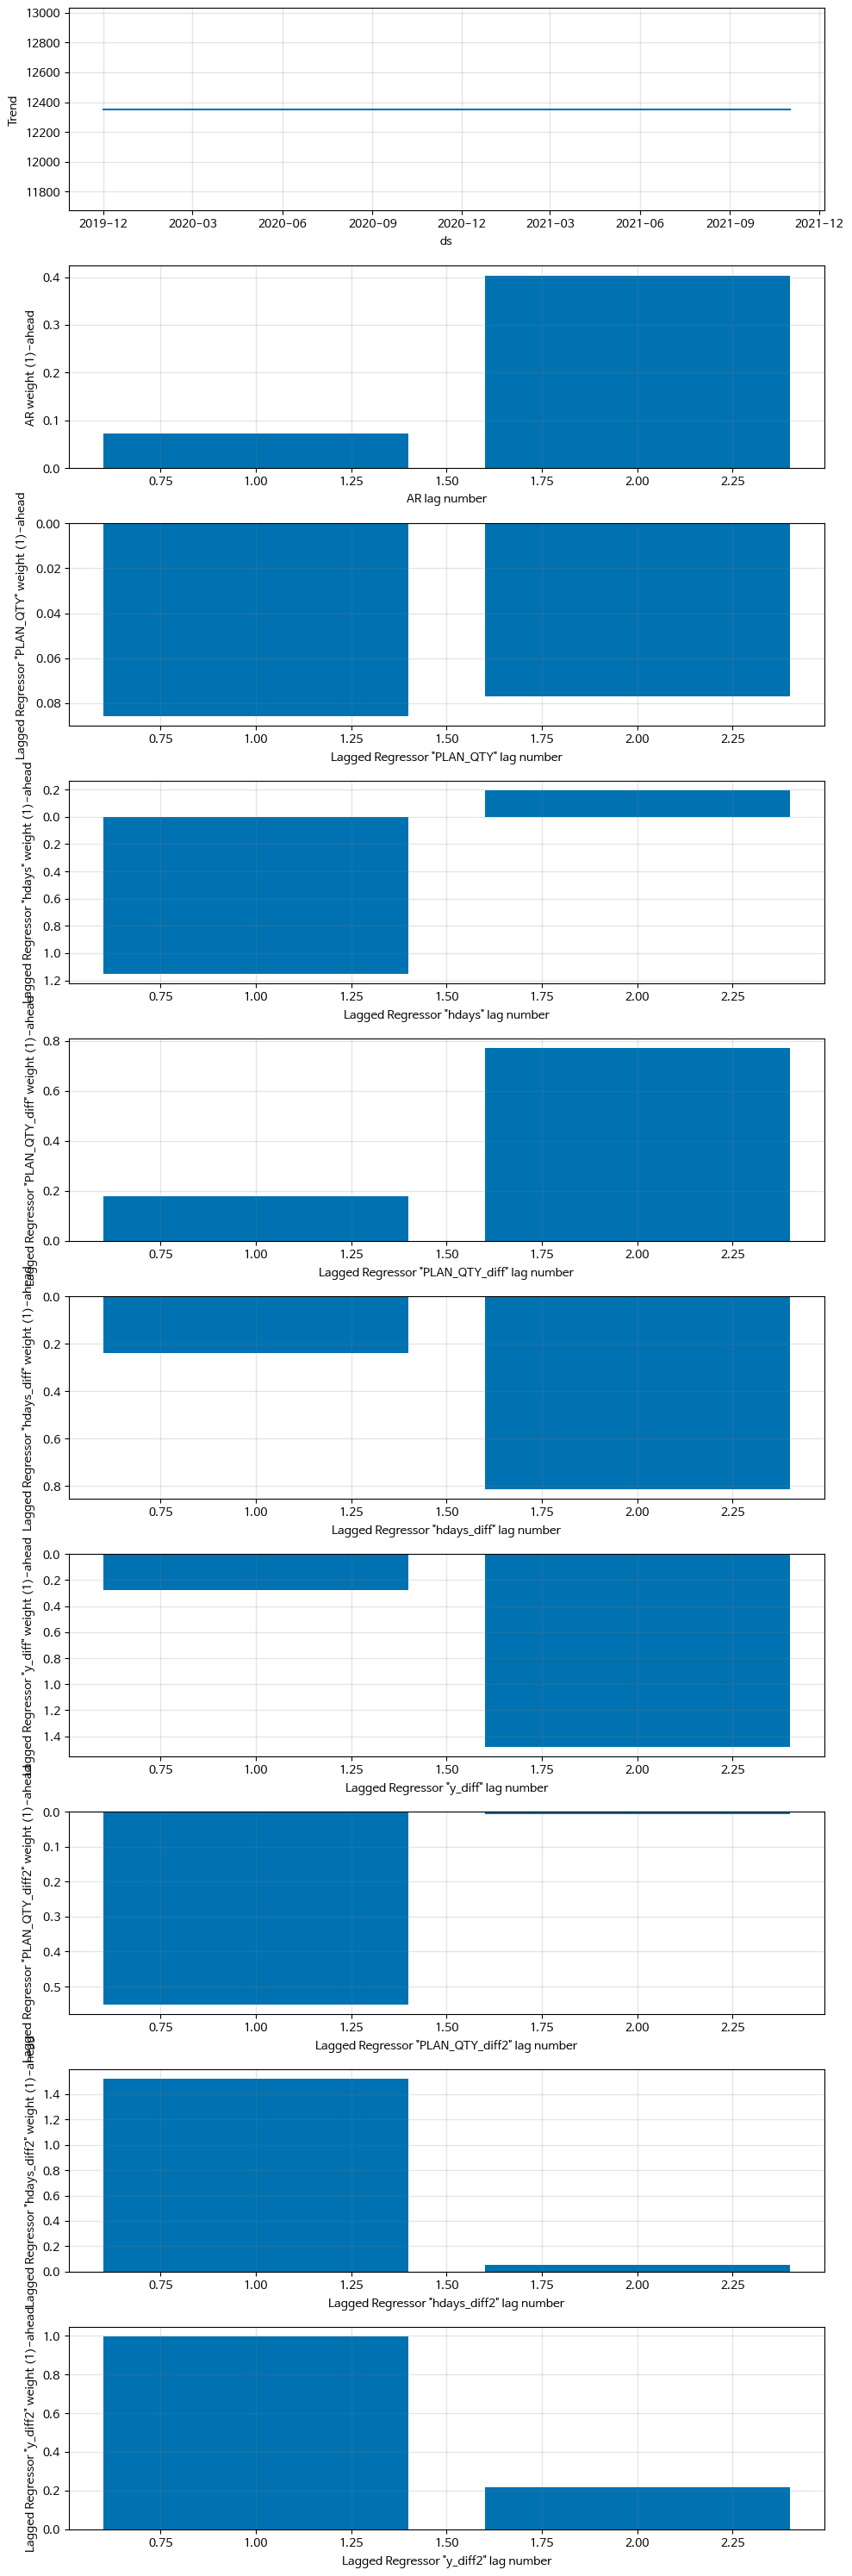

In [145]:
#학습 데이터셋 예측 결과 시각화
train_pred = m.predict(train2)
#fig = m.plot(train_pred)
fig1 = m.plot(train_pred[-30*24*6:])
fig2 = m.plot(train_pred[-7*24*6:])
#comp = m.plot_components(train_pred)
param = m.plot_parameters()

In [146]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

col = "y"

#학습 데이터셋 검증
pred2 = train_pred["y"]
test2 = train_pred['yhat1'].fillna('0')
print("============== {} train Evaluate Result============".format(col))
print("MAE :", mean_absolute_error(test2, pred2))
print("MSE :", mean_squared_error(test2, pred2))
print("RMSE :", (mean_squared_error(test2, pred2))**(1/2))
print("MAPE :", mean_absolute_percentage_error(test2, pred2))

============== y train Evaluate Result============
MAE : 3575.178955078125
MSE : 20111751.54016717
RMSE : 4484.6127525313905
MAPE : 3.0196635501519176e+18


In [147]:
#테스트 데이터셋 검증
pred2 = test_pred["y"]
test2 = test_pred['yhat1'].fillna('0')
print("============== {} test Evaluate Result============".format(col))
print("MAE :", mean_absolute_error(test2, pred2))
print("MSE :", mean_squared_error(test2, pred2))
print("RMSE :", (mean_squared_error(test2, pred2))**(1/2))
print("MAPE :", mean_absolute_percentage_error(test2, pred2))

============== y test Evaluate Result============
MAE : 3704.7236328125
MSE : 13884398.812913895
RMSE : 3726.177506898174
MAPE : 9.241386435364258e+18
